In [1]:
import pandas as pd
#import itertools

from spacy.language import Language
# nlp = Language(Vocab())
from tqdm import tqdm_notebook

from wordcloud import WordCloud

import es_core_news_sm
nlp = es_core_news_sm.load()
from spacy.lang.es.stop_words import STOP_WORDS

import gensim
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Load data set

In [2]:
data = pd.read_excel('../data/Estrategias_Estudiantes_A1.xlsx')

#### Count words

In [3]:
def count_words(text):
    return len(str(text).split())

In [4]:
data['n_words'] = data['A-Q1'].apply(count_words)

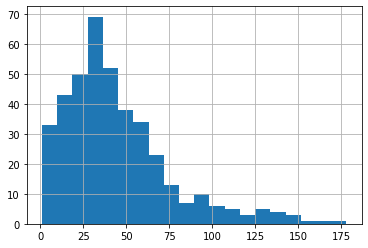

In [5]:
data.n_words.hist(bins=20);

In [6]:
data.n_words.describe()

count    401.000000
mean      44.441397
std       31.571857
min        1.000000
25%       22.000000
50%       37.000000
75%       58.000000
max      178.000000
Name: n_words, dtype: float64

(In fact, the minimum of written words is 0.)

#### Drop empty rows

In [7]:
ind_drop = [i for i in data.index if data.loc[i,'A-Q1']==0]

data = data.drop(ind_drop).reset_index(drop=True)

data.rename(columns={'Unnamed: 0':'Index_survey'}, inplace=True)

In [8]:
data.head()

,Index_survey,A-Q1,n_words
0,0,Similitud con otros idiomas. Composición con a...,14
1,1,"Relaciono terminaciónes, palabras compuestas d...",30
2,2,Estoy en un A1.1 de alemán o sea que no sé dem...,111
3,3,Principalmente me fijo en la terminación de la...,129
4,4,Relacionarlas con palabras conocidas de mi len...,33


#### Drop text without answer

In [9]:
#data[data['n_words'] <= 10] # controll for short answers that might be comments

Some students didn't write answers in the text field but other comments instead. We have to exclude these comments from the analysis.

In [10]:
ind_drop1 = []

for j, wert in enumerate(data['A-Q1']):
    if 'rellenad' in str(wert):
        ind_drop1.append(j)

for j, wert in enumerate(data['A-Q1']):
    if '1era vez' in str(wert):
        ind_drop1.append(j)

ind_drop1

[205, 206, 55]

In [11]:
data = data.drop(ind_drop1).reset_index(drop=True)

In [12]:
data.n_words.describe()

count    387.000000
mean      45.994832
std       31.041840
min        2.000000
25%       24.000000
50%       39.000000
75%       60.000000
max      178.000000
Name: n_words, dtype: float64

#### Standardise different spellings

In [13]:
def multiple_replace(text):
    dic = {r'á' : 'a', 'é' : 'e', 'í' : 'i', 'ó' : 'o', 'ú' : 'u'}
    # Create a regular expression from the dictionary keys
    regex = re.compile("(%s)" % "|".join(map(re.escape, dic.keys())))
    # For each match, look-up corresponding value in dictionary
    return regex.sub(lambda mo: dic[mo.string[mo.start():mo.end()]], text.lower())

In [14]:
data['clean_text'] = data['A-Q1'].apply(multiple_replace)

#### Define stop words

In [15]:
not_stop_words = ['breve','cuanta', 'cuantas', 'cuanto', 'cuantos', 'diferente', 'diferentes', 'donde',
                 'enseguida', 'excepto', 'junto', 'otra', 'otras', 'otro', 'otros', 'pasada', 'pasado', 'propia', 'propias',
                 'propio', 'propios', 'proximo','proximos', 'siguiente', 'ultimo', 'ultima', 'ultimos', 'ultimas']
# general, gran, grandes, incluso, lado, largo, mediante, mientras, mucho/a/s, ningun/o/a/s, posible, primer/a/s, principalmente,
# raras, segunda/o, tambien, tercera, toda/o/s
# como, ejemplo

for word in not_stop_words:
    nlp.vocab[word].is_stop = False

STOP_WORDS = [word for word in STOP_WORDS if word not in not_stop_words]

##### Check list of frequent words for stop words

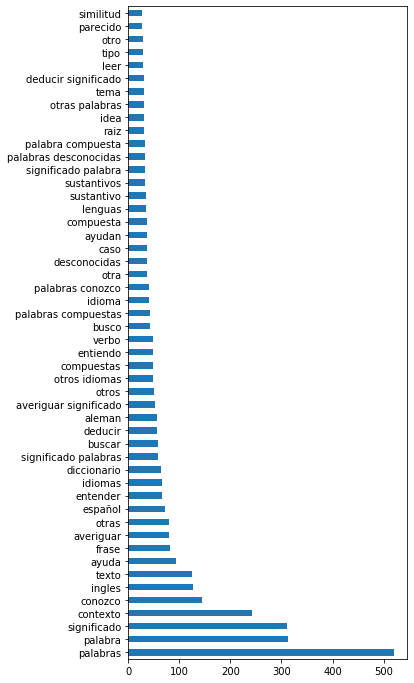

In [16]:
vectorizer = CountVectorizer(ngram_range=(1,3),stop_words=STOP_WORDS)
docs       = vectorizer.fit_transform([str(l) for l in list(data['clean_text'].values)])
features   = vectorizer.get_feature_names()
voc_count = pd.Series(np.array(docs.sum(axis=0)).reshape(-1), index=features)
voc_count.sort_values(ascending=False)[:50].plot(kind='barh', figsize=(5,12));

In [17]:
new_stop_words = ['palabra', 'palabras', 'significa', 'significan', 'significar', 'significado', 'significados', 'averiguo', 'averiguar',
                 'busco','buscar','descubro', 'descubrir', 'desconocida', 'desconocidas', 'desconocido', 'desconocidos',
                'desconozco','trato','tratar','intento','intentar','suelo','normalmente','ayuda','ayudan', 'gracias',
                 'entender','entenderla','entenderlas','entenderlo','comprender','comprenderla','comprenderlas',
                 'uso','usar','utilizo','utilizar','utilizando','algun','estrategia','estrategias','tecnica','tecnicas',
                 'miro','mirar','etc']

for word in new_stop_words:
    nlp.vocab[word].is_stop = True

STOP_WORDS += new_stop_words

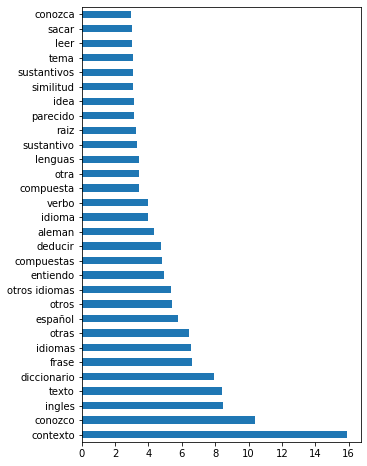

In [18]:
vectorizer = TfidfVectorizer(ngram_range=(1,3),stop_words=STOP_WORDS)
docs       = vectorizer.fit_transform([str(l) for l in list(data['clean_text'].values)])
features   = vectorizer.get_feature_names()
voc_count = pd.Series(np.array(docs.sum(axis=0)).reshape(-1), index=features)
voc_count.sort_values(ascending=False)[:30].plot(kind='barh', figsize=(5,8));

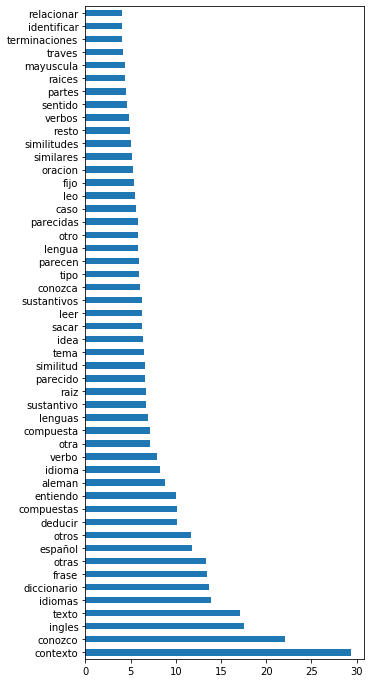

In [19]:
vectorizer = TfidfVectorizer(ngram_range=(1,1),stop_words=STOP_WORDS)
docs       = vectorizer.fit_transform([str(l) for l in list(data['clean_text'].values)])
features   = vectorizer.get_feature_names()
voc_count = pd.Series(np.array(docs.sum(axis=0)).reshape(-1), index=features)
voc_count.sort_values(ascending=False)[:50].plot(kind='barh', figsize=(5,12));

In [20]:
vectorizer = CountVectorizer(ngram_range=(1,1),stop_words=STOP_WORDS)
docs       = vectorizer.fit_transform([str(l) for l in list(data['clean_text'].values)])
features   = vectorizer.get_feature_names()
voc_count = pd.Series(np.array(docs.sum(axis=0)).reshape(-1), index=features)
voc_count.sort_values(ascending=False)[:50]

contexto       242
conozco        145
ingles         127
texto          124
frase           82
otras           80
español         72
idiomas         66
diccionario     64
deducir         57
aleman          56
otros           51
entiendo        48
verbo           48
compuestas      48
idioma          41
otra            37
caso            37
compuesta       36
lenguas         34
sustantivo      34
sustantivos     33
idea            31
raiz            31
tema            30
leer            29
tipo            28
otro            28
conozca         27
similitud       27
parecido        27
fijo            26
lengua          26
sacar           26
verbos          25
oracion         24
leo             24
sentido         24
similares       22
partes          19
parecidas       19
mayuscula       19
raices          19
parecen         18
pensar          18
adjetivo        18
suelen          18
resto           17
identificar     17
resulta         17
dtype: int64

In [21]:
vectorizer = CountVectorizer(ngram_range=(3,5), stop_words=STOP_WORDS)
docs       = vectorizer.fit_transform([str(l) for l in list(data['clean_text'].values)])
features   = vectorizer.get_feature_names()
voc_count = pd.Series(np.array(docs.sum(axis=0)).reshape(-1), index=features)
voc_count.sort_values(ascending=False)[:30]

otros idiomas ingles            9
otros idiomas conozco           7
verbo sustantivo adjetivo       5
similares otros idiomas         5
parecidas otros idiomas         4
otras lenguas ingles            4
otro idioma ingles              4
conozco otros idiomas           4
tipo sustantivo adjetivo        4
otras otros idiomas             4
ingles frances español          4
parecidos otros idiomas         4
similitud otro idioma           4
idiomas ingles frances          3
similitudes otros idiomas       3
leo texto entero                3
lenguas ingles frances          3
conozco ingles español          3
similitud otro idioma ingles    3
otras lenguas ingles frances    3
parecido otros idiomas          3
otras lenguas conozco           3
deducir contexto frase          3
empieza mayuscula sustantivo    3
verbo adjetivo sustantivo       3
sustantivo adjetivo verbo       3
otras otro idioma               3
materno otro idioma             2
haben dabei nichts verloren     2
parezcan otros

In [22]:
vectorizer = CountVectorizer(ngram_range=(3,5))
docs       = vectorizer.fit_transform([str(l) for l in list(data['clean_text'].values)])
features   = vectorizer.get_feature_names()
voc_count = pd.Series(np.array(docs.sum(axis=0)).reshape(-1), index=features)
voc_count.sort_values(ascending=False)[:50]

el significado de                 105
las palabras que                   74
de las palabras                    68
por el contexto                    64
de la palabra                      51
averiguar el significado           40
de la frase                        34
palabras que no                    29
averiguar el significado de        29
que ya conozco                     28
significado de las                 27
el significado de las              25
las palabras que no                22
una palabra compuesta              22
que no conozco                     21
significado de la                  21
el significado de la               21
en el que                          21
en el contexto                     21
tipo de palabra                    21
el contexto en                     20
la palabra en                      20
el significado de las palabras     20
me fijo en                         20
significado de las palabras        20
de las palabras que                20
las palabras

#### Get tokens and lemmas for analysis

In [23]:
f = vectorizer.build_analyzer()

In [24]:
#'espanol' in vectorizer.get_feature_names()

In [25]:
#f(data.loc[0,'clean_text'])

In [26]:
data['tokens'] = data['clean_text'].apply(f)

In [27]:
def tokenize_and_lemm_spacy(text):
    text = str(text)
    doc = nlp(text)
    lemmas = []
    for token in doc:
        if token.is_stop== False: # aprovechamos para eliminar ya las stopwords
            if token.is_alpha== True: # Nos quedamos solo con los tokens que contienen letras
                if token.pos_ not in ['CONJ', 'ADP', 'DET']: # eliminamos nombres propios, conjunciones, determinantes
                    lemmas.append(token.lemma_.lower())
    return lemmas

In [28]:
data['lemmas'] = data['clean_text'].apply(tokenize_and_lemm_spacy)

In [29]:
data.head()

,Index_survey,A-Q1,n_words,clean_text,tokens,lemmas
0,0,Similitud con otros idiomas. Composición con a...,14,similitud con otros idiomas. composicion con a...,"[similitud con otros, con otros idiomas, otros...","[similitud, idioma, composicion, aleman, conoc..."
1,1,"Relaciono terminaciónes, palabras compuestas d...",30,"relaciono terminaciones, palabras compuestas d...","[relaciono terminaciones palabras, terminacion...","[relacionar, terminación, componer, conocer, p..."
2,2,Estoy en un A1.1 de alemán o sea que no sé dem...,111,estoy en un a1.1 de aleman o sea que no se dem...,"[estoy en un, en un a1, un a1 de, a1 de aleman...","[aleman, leer, frase, entero, contexto, casar,..."
3,3,Principalmente me fijo en la terminación de la...,129,principalmente me fijo en la terminacion de la...,"[principalmente me fijo, me fijo en, fijo en l...","[fijar, terminacion, acabar, ung, eit, ion, de..."
4,4,Relacionarlas con palabras conocidas de mi len...,33,relacionarlas con palabras conocidas de mi len...,"[relacionarlas con palabras, con palabras cono...","[relacionarlas, conocido, lengua, materno, len..."


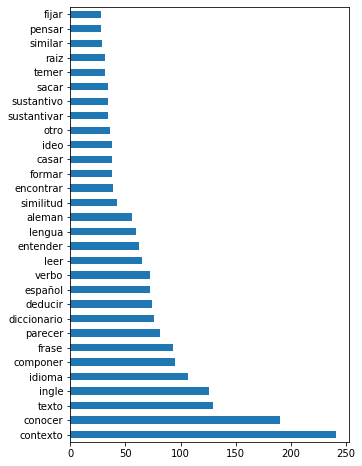

In [30]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform([' '.join(tok) for tok in data['lemmas']])
features   = vectorizer.get_feature_names()
voc_count = pd.Series(np.array(docs.sum(axis=0)).reshape(-1), index=features)
voc_count.sort_values(ascending=False)[:30].plot(kind='barh', figsize=(5,8));

In [31]:
voc_count[[el for el in voc_count.index if 'preg' in el]]

preguntandose    1
preguntar        5
preguntarle      1
preguntarme      1
preguntarse      1
dtype: int64

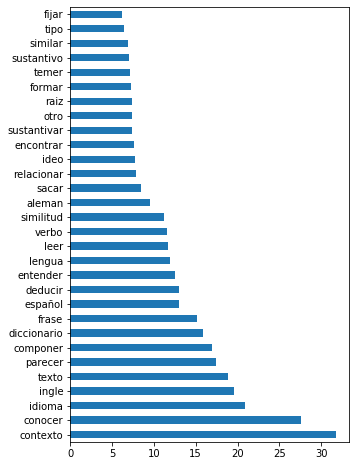

In [32]:
vectorizer = TfidfVectorizer()
docs       = vectorizer.fit_transform([' '.join(tok) for tok in data['lemmas']])
features   = vectorizer.get_feature_names()
voc_count = pd.Series(np.array(docs.sum(axis=0)).reshape(-1), index=features)
voc_count.sort_values(ascending=False)[:30].plot(kind='barh', figsize=(5,8));

## Word Cloud

### Total

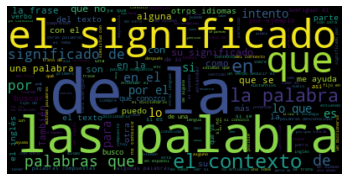

In [33]:
text = ' '.join([str(el) for el in data['A-Q1']])
wordcloud = WordCloud().generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Tokens

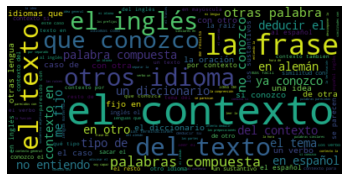

In [34]:
tokens = data['A-Q1'].apply(f)
txt_tok = ' '.join([' '.join(tok) for tok in tokens])
wordcloud = WordCloud(stopwords=STOP_WORDS).generate(txt_tok)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Lemmas

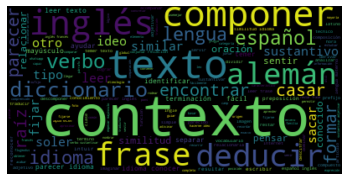

In [35]:
lemmas = data['A-Q1'].apply(tokenize_and_lemm_spacy)
txt_lem = ' '.join([' '.join(lem) for lem in lemmas])
wordcloud = WordCloud(stopwords=STOP_WORDS).generate(txt_lem)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Save new file for further analysis

In [36]:
#data.to_pickle('../data/Voc_strat_text.pickle')